# Training an autoregressive KS Emulator in JAX

This notebook demonstrates how to train a **convolutional ResNet** to become an
autoregressive emulator for the Kuramoto-Sivashinsky (KS) equation:

$$
\frac{\partial u}{\partial t} = -\frac{1}{2} \frac{\partial u^2}{\partial x} - \frac{\partial^2 u}{\partial x^2} - \frac{\partial^4 u}{\partial x^4}
$$

with periodic boundary conditions on the domain $x \in [0, 100.0]$.

The KS equation experiences spatio-temporal chaos which is an equilibrium of:

* The negative diffusion "producing new energy" in lower modes
* The nonlinear convection moving the energy between modes
* The hyper-diffusion dissipating energy in higher modes

### Reference simulator

We will use a second-order Fourier pseudo-spectral method to produce reference
trajectories starting from random initial conditions (with zero mean). They will be warmed up to
reach the chaotic attractor.

In [2]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import equinox as eqx
import optax
from tqdm.autonotebook import tqdm

In [3]:
DOMAIN_SIZE = 100.0
NUM_DOF = 256
DT = 0.2

In [4]:
NUM_SAMPLES_TRAIN = 30
TRAIN_TEMPORAL_HORIZON = 100
NUM_WARMUP_STEPS = 500

In [5]:
NUM_SAMPLES_TEST = 20
TEST_TEMPORAL_HORIZON = 200

In [6]:
# Find more details here: https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/fft_and_spectral_methods/ks_solver_etd_in_jax.ipynb
# and here: https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/fft_and_spectral_methods/ks_solver_etd_and_etdrk2_in_jax.ipynb
# Different from the notebooks (and the associated video), we will dealias before evaluating the nonlinearity

class KS_ETDRK2():
    def __init__(
        self,
        L,
        N,
        dt,
    ):
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L / N

        wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
        self.derivative_operator = 1j * wavenumbers

        linear_operator = - self.derivative_operator**2 - self.derivative_operator**4
        self.exp_term = jnp.exp(dt * linear_operator)
        self.coef_1 = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )
        self.coef_2 = jnp.where(
            linear_operator == 0.0,
            dt / 2,
            (self.exp_term - 1.0 - linear_operator * dt) / (linear_operator**2 * dt)
        )

        self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))
    
    def __call__(
        self,
        u,
    ):
        u_nonlin = - 0.5 * u**2
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat
        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        u_stage_1_hat = self.exp_term * u_hat + self.coef_1 * u_nonlin_der_hat
        u_stage_1 = jnp.fft.irfft(u_stage_1_hat, n=self.N)

        u_stage_1_nonlin = - 0.5 * u_stage_1**2
        u_stage_1_nonlin_hat = jnp.fft.rfft(u_stage_1_nonlin)
        u_stage_1_nonlin_der_hat = self.derivative_operator * u_stage_1_nonlin_hat

        u_next_hat = u_stage_1_hat + self.coef_2 * (u_stage_1_nonlin_der_hat - u_nonlin_der_hat)
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)

        return u_next


In [7]:
ks_etdrk2_stepper = KS_ETDRK2(DOMAIN_SIZE, NUM_DOF, DT)

In [8]:
u_0 = jax.random.normal(jax.random.PRNGKey(0), (NUM_SAMPLES_TRAIN, 1, NUM_DOF))

# KS requires zero mean initial conditions
u_0 = jax.vmap(lambda u: u - jnp.mean(u))(u_0)

In [9]:
# Find more details in this video: https://youtu.be/NlcOQ9fGq-w

def rollout(
    stepper_fn,
    n,
    *,
    include_init = False,
):
    """
    Transform an autonomous timestepper into a function that efficiently unrolls
    a trajectory.
    """
    def scan_fn(u, _):
        u_next = stepper_fn(u)
        return u_next, u_next

    def rollout_fn(init):
        _, history = jax.lax.scan(
            scan_fn,
            init,
            None,
            length=n,
        )

        if include_init:
            return jnp.concatenate([
                jnp.expand_dims(init, axis=0),
                history,
            ], axis=0)
        else:
            return history
    
    return rollout_fn

In [16]:
trj_with_warmup = jax.vmap(
    rollout(ks_etdrk2_stepper, TRAIN_TEMPORAL_HORIZON + NUM_WARMUP_STEPS, include_init=True)
)(u_0)

In [17]:
trj_with_warmup.shape

(30, 601, 1, 256)

Text(0, 0.5, 'space')

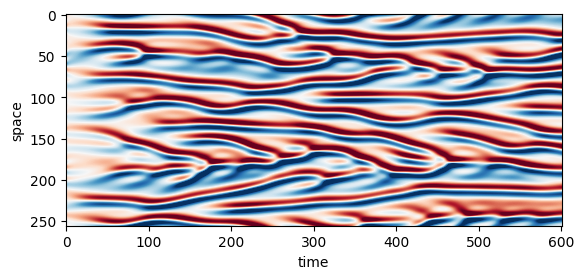

In [18]:
plt.imshow(trj_with_warmup[0, :, 0, :].T, cmap="RdBu_r", vmin=-2, vmax=2)
plt.xlabel("time")
plt.ylabel("space")

In [19]:
trj = trj_with_warmup[:, NUM_WARMUP_STEPS:]

trj.shape

(30, 101, 1, 256)

Text(0, 0.5, 'space')

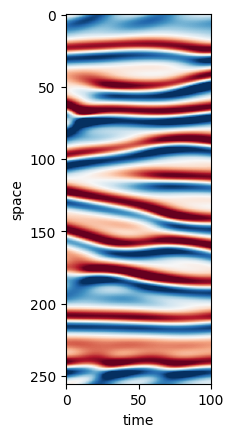

In [20]:
plt.imshow(trj[0, :, 0, :].T, cmap="RdBu_r", vmin=-2, vmax=2)
plt.xlabel("time")
plt.ylabel("space")

In [21]:
u_0_test = jax.random.normal(jax.random.PRNGKey(1), (NUM_SAMPLES_TEST, 1, NUM_DOF))

u_0_test = jax.vmap(lambda u: u - jnp.mean(u))(u_0_test)

In [22]:
u_0_test.shape

(20, 1, 256)

In [24]:
trj_test = jax.vmap(
    rollout(ks_etdrk2_stepper, TEST_TEMPORAL_HORIZON + NUM_WARMUP_STEPS, include_init=True)
)(u_0_test)[:, NUM_WARMUP_STEPS:]

trj_test.shape

(20, 201, 1, 256)

In [38]:
def slice_windows_of_two(one_trj):
    num_time_steps = one_trj.shape[0]

    windows = []
    for i in range(num_time_steps-1):
        windows.append(one_trj[i:i+2])
    
    return jnp.stack(windows)

In [40]:
sub_trj = jax.vmap(slice_windows_of_two)(trj)

# (NUM_SAMPLES_TRAIN, NUM_SUB_TRAJECTORIES, 2, 1, NUM_DOF)
sub_trj.shape

(30, 100, 2, 1, 256)

In [42]:
# Merge the two batch axes
train_data = jnp.concatenate(sub_trj)

# (NUM_SAMPLES_TRAIN * NUM_SUB_TRAJECTORIES, 2, 1, NUM_DOF)
train_data.shape

(3000, 2, 1, 256)

Text(0.5, 0, 'Space')

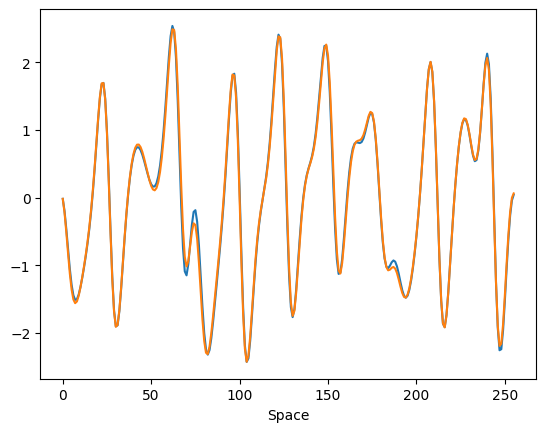

In [47]:
plt.plot(train_data[0, :, 0, :].T)
plt.xlabel("Space")

In [48]:
from typing import Callable

class ResBlockPostActivationPeriodic1d(eqx.Module):
    conv_1: eqx.nn.Conv1d
    conv_2: eqx.nn.Conv1d
    activation: Callable

    def __init__(
        self,
        hidden_channels: int,
        activation: Callable,
        *,
        key,
    ):
        c_1_key, c_2_key = jax.random.split(key)

        # Requires an up-to-dat version of Equinox
        self.conv_1 = eqx.nn.Conv1d(
            hidden_channels,
            hidden_channels,
            kernel_size=3,
            padding="SAME",
            padding_mode="CIRCULAR",
            key=c_1_key
        )
        self.conv_2 = eqx.nn.Conv1d(
            hidden_channels,
            hidden_channels,
            kernel_size=3,
            padding="SAME",
            padding_mode="CIRCULAR",
            key=c_2_key
        )

        self.activation = activation

    def __call__(
        self,
        x,
    ):
        x_skip = x
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.conv_2(x)
        x = x + x_skip
        x = self.activation(x)

        return x

In [49]:
class ResNetPeriodic1d(eqx.Module):
    lifting: eqx.nn.Conv1d
    blocks: list[ResBlockPostActivationPeriodic1d]
    projection: eqx.nn.Conv1d

    def __init__(
        self,
        hidden_channels,
        num_blocks,
        activation,
        *,
        key,
    ):
        l_key, *block_keys, p_key = jax.random.split(key, num_blocks+2)

        self.lifting = eqx.nn.Conv1d(1, hidden_channels, kernel_size=1, key=l_key)
        self.blocks = [
            ResBlockPostActivationPeriodic1d(hidden_channels, activation, key=k)
            for k in block_keys
        ]
        self.projection = eqx.nn.Conv1d(hidden_channels, 1, kernel_size=1, key=p_key)

    def __call__(self, x):
        x = self.lifting(x)
        for block in self.blocks:
            x = block(x)
        x = self.projection(x)

        return x

In [50]:
def dataloader(
    data,
    *,
    batch_size: int,
    key,
):
    """
    Loop generator over the data. The data can be a PyTree or an Array. For
    supervised learning problems you can also hand over a tuple of Arrays
    (=PyTree).
    """

    n_samples_list = [a.shape[0] for a in jtu.tree_leaves(data)]

    if not all(n == n_samples_list[0] for n in n_samples_list):
        raise ValueError(
            "All arrays / PyTree leaves must have the same number of samples. (Leading array axis)"
        )

    n_samples = n_samples_list[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        sub_data = jtu.tree_map(lambda a: a[batch_indices], data)

        yield sub_data

In [51]:
HIDDEN_CHANNELS = 26
NUM_BLOCKS = 5
ACTIVATION = jax.nn.relu
INIT_SEED = 42
LEARNING_RATE = 3e-4
SHUFFLE_SEED = 99
NUM_EPOCHS = 30
BATCH_SIZE = 20

ks_res_net_emulator = ResNetPeriodic1d(HIDDEN_CHANNELS, NUM_BLOCKS, ACTIVATION, key=jax.random.PRNGKey(INIT_SEED))

optimizer = optax.adam(LEARNING_RATE)

opt_state = optimizer.init(eqx.filter(ks_res_net_emulator, eqx.is_array))

def loss_fn(model, batch):
    x, y = batch[:, 0], batch[:, 1]
    y_pred = jax.vmap(model)(x)
    mse = jnp.mean(jnp.square(y_pred - y))
    return mse

@eqx.filter_jit
def step_fn(model, state, batch):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, batch)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

shuffle_key = jax.random.PRNGKey(SHUFFLE_SEED)
train_loss_history = []

for epoch in tqdm(range(NUM_EPOCHS)):
    shuffle_key, subkey = jax.random.split(shuffle_key)

    for batch in tqdm(dataloader(train_data, batch_size=BATCH_SIZE, key=subkey)):
        ks_res_net_emulator, opt_state, loss = step_fn(ks_res_net_emulator, opt_state, batch)

        train_loss_history.append(loss)

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Text(0, 0.5, 'Train Loss')

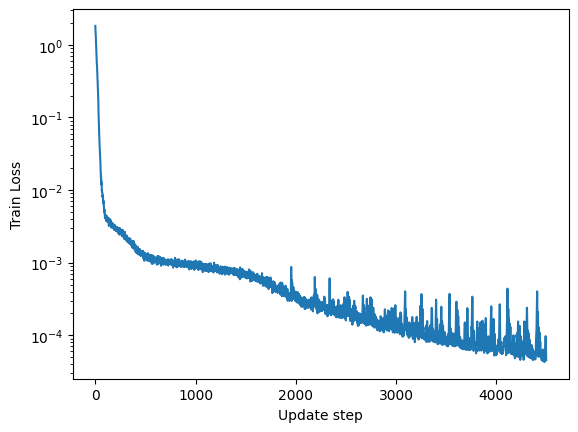

In [53]:
plt.semilogy(train_loss_history)
plt.xlabel("Update step")
plt.ylabel("Train Loss")

In [54]:
test_prediction = jax.vmap(
    rollout(ks_res_net_emulator, TEST_TEMPORAL_HORIZON, include_init=True)
)(trj_test[:, 0])

In [55]:
test_prediction.shape

(20, 201, 1, 256)

In [56]:
trj_test.shape

(20, 201, 1, 256)

In [57]:
def nRMSE(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)

    return diff_norm / ref_norm

In [58]:
test_nRMSE_trj_set = jax.vmap(jax.vmap(nRMSE))(test_prediction, trj_test)

test_nRMSE_trj_set.shape

(20, 201)

In [59]:
mean_test_nRMSE_trj = jnp.mean(test_nRMSE_trj_set, axis=0)

In [60]:
mean_test_nRMSE_trj.shape

(201,)

Text(0, 0.5, 'mean-nRMSE')

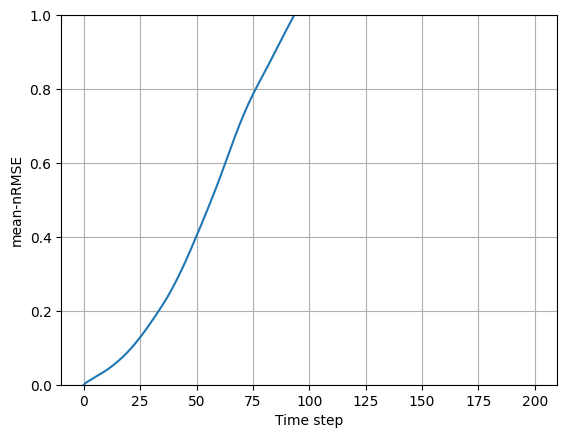

In [61]:
plt.plot(mean_test_nRMSE_trj)
plt.ylim(0, 1)
plt.grid()
plt.xlabel("Time step")
plt.ylabel("mean-nRMSE")

In [62]:
def correlation(pred, ref):
    pred_normalized = pred / jnp.linalg.norm(pred)
    ref_normalized = ref / jnp.linalg.norm(ref)

    return jnp.dot(pred_normalized.flatten(), ref_normalized.flatten())

In [63]:
test_corr_trj_set = jax.vmap(jax.vmap(correlation))(test_prediction, trj_test)

(0.0, 1.0)

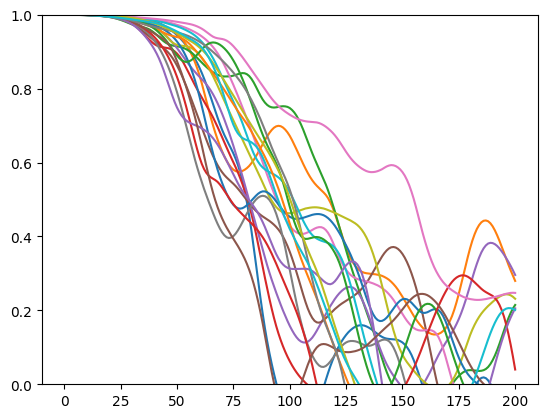

In [65]:
plt.plot(test_corr_trj_set.T);
plt.ylim(0, 1)

In [66]:
mean_test_corr_trj = jnp.mean(test_corr_trj_set, axis=0)

Text(0, 0.5, 'Mean Correlation')

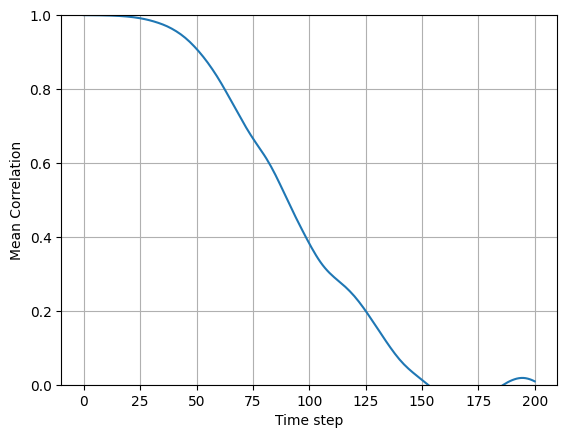

In [68]:
plt.plot(mean_test_corr_trj)
plt.ylim(0, 1)
plt.grid()
plt.xlabel("Time step")
plt.ylabel("Mean Correlation")

After 50 steps, correlation is below 0.9. Hence, with dt=0.2, this means 10 time units of high correlation

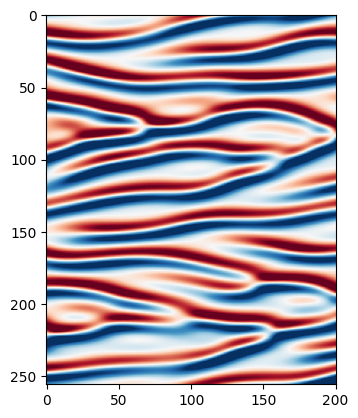

In [70]:
plt.imshow(test_prediction[0, :, 0, :].T, cmap="RdBu_r", vmin=-2, vmax=2)

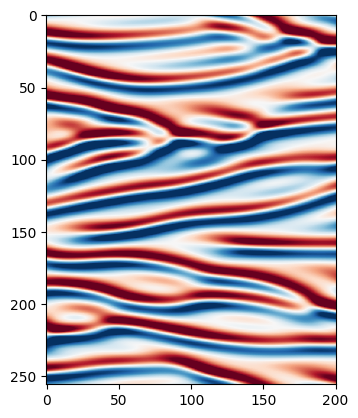

In [71]:
plt.imshow(trj_test[0, :, 0, :].T, cmap="RdBu_r", vmin=-2, vmax=2)

In [72]:
very_long_prediction = jax.vmap(rollout(ks_res_net_emulator, 500, include_init=True))(trj_test[:, 0])

very_long_prediction = very_long_prediction[:, -200:]

In [73]:
very_long_prediction_hat = jnp.fft.rfft(very_long_prediction)

In [74]:
very_long_prediction_hat_abs_squared = jnp.abs(very_long_prediction_hat)**2

In [75]:
very_long_prediction_hat_abs_squared.shape

(20, 200, 1, 129)

In [76]:
very_long_prediction_hat_abs_squared_mean = jnp.mean(very_long_prediction_hat_abs_squared, axis=(0, 1, 2))

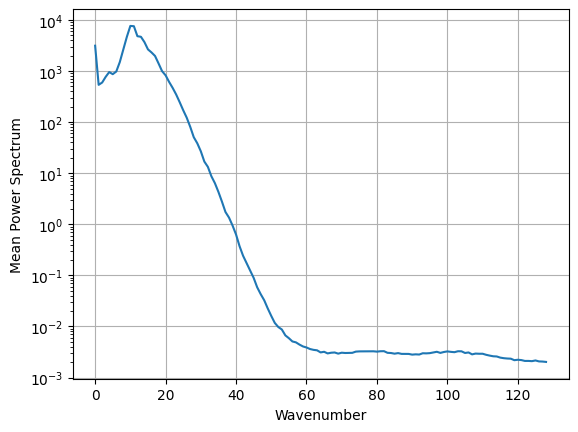

In [77]:
plt.semilogy(very_long_prediction_hat_abs_squared_mean)
plt.xlabel("Wavenumber")
plt.ylabel("Mean Power Spectrum")
plt.grid()

In [78]:
very_long_test_trj = jax.vmap(rollout(ks_etdrk2_stepper, 500, include_init=True))(trj_test[:, 0])

very_long_test_trj = very_long_test_trj[:, -200:]

In [79]:
very_long_test_trj_hat = jnp.fft.rfft(very_long_test_trj)

In [80]:
very_long_test_trj_hat_abs_squared = jnp.abs(very_long_test_trj_hat)**2

In [81]:
very_long_test_trj_hat_abs_squared_mean = jnp.mean(very_long_test_trj_hat_abs_squared, axis=(0, 1, 2))

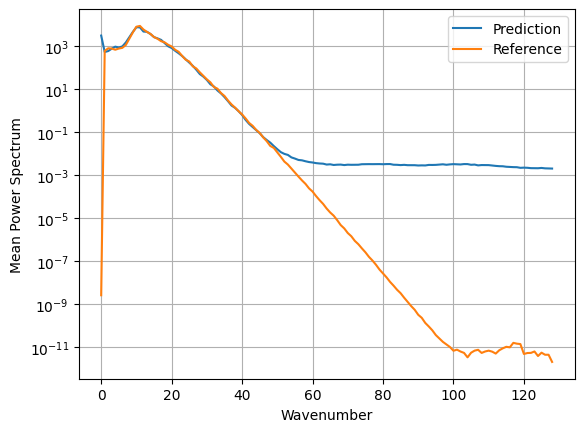

In [82]:
plt.semilogy(very_long_prediction_hat_abs_squared_mean, label="Prediction")
plt.semilogy(very_long_test_trj_hat_abs_squared_mean, label="Reference")
plt.xlabel("Wavenumber")
plt.ylabel("Mean Power Spectrum")
plt.grid()
plt.legend()